**FGP-rOEEE**

Implementation of algorithm used in https://dl.acm.org/doi/10.1145/3387902.3392617.

The algorithm partitions a circuit in slices, using a graph for each time-step of the circuit, which includes large-weight (infinite) edges for interactions at the given time-step and time-decaying weights (exponential used here) for future interactions.

The *partition* here is a list which tells us which partition each qubit is assigned to $[\phi(q_0), \phi(q_1),..., \phi(q_{N_q})]$, which determines the local and non-local interactions. *Valid* partitions are defined as those for which all interactions at the current time-step are local. The final solution we are looking for is a list of valid partitions, one for each time-step of the circuit.

The algorithm starts with some heuristic for providing a starting partition for the static interaction graph, which is a graph with all interactions from the circuit summed into edges. It is also possible here to specify an initial partition, such that an external initial partitioning heuristic can be used (use the choose initial kwarg). If not, the static-OEE algorithm is used. There is also a kwarg "remove_singles" which removes layers which have single qubit gates only. This reduces the depth but makes it harder to extract a circuit afterwards - I choose to keep the single qubit gates in so I can visualise the result afterwards, it does't make a complexity difference because these layers are automatically valid from the previous layer.

The *main_algorithm* produces the list of graphs and performs the fgp algorithm to produce a list of partitions. It also tracks and returns a *mapping*, which is a one-to-one mapping of circuit qubits to physical qubits. It doesn't affect the teleportation cost, but it is useful for visualising the result.

In [11]:
from disqco.parti.fgp.fgp_roee import *
from qiskit.circuit.library import QuantumVolume, QFT
from qiskit import transpile
import time
from disqco.circuits.cp_fraction import *

# Define the number of qubits and the circuit

num_qubits = 8

circuit = QuantumVolume(num_qubits, depth=6)

# circuit = QFT(num_qubits, do_swaps=False)

# circuit = cp_fraction(num_qubits, num_qubits, fraction=0.3)
# Transpile the circuit into some basis gates. The gate set here was used to match those used in teh GCP paper, but it shouldn't matter which gates are used.
# basis_gates = ['cx','h', 'rz']

basis_gates = ['cp','u']




transpiled_circuit = transpile(circuit, basis_gates=basis_gates)
print(circuit.count_ops())
# Define the number of partitions
num_partitions = 4

# Define the QPU sizes in terms of data qubit capacity, here they are defined to be equal and match the number of qubits in the circuit, with an extra space in each QPU.

qpu_sizes = [int(num_qubits/num_partitions) for _ in range(num_partitions)]


initial_partition = set_initial_partition_fgp(qpu_info=qpu_sizes,num_partitions=num_partitions)

start = time.time()
partition, cost, mapping = main_algorithm(circuit=transpiled_circuit, 
                                          qpu_info=qpu_sizes,
                                          initial_partition=initial_partition,
                                          remove_singles=False,
                                          choose_initial=True)
stop = time.time()

print(f"Teleportation cost: {cost}", f"Time taken: {stop-start}")

OrderedDict({'quantum_volume_[8,6,41284778729944710019263961648648688921]': 1})
Initial cost of partition:  69
Teleportation cost: 24 Time taken: 0.003942966461181641


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


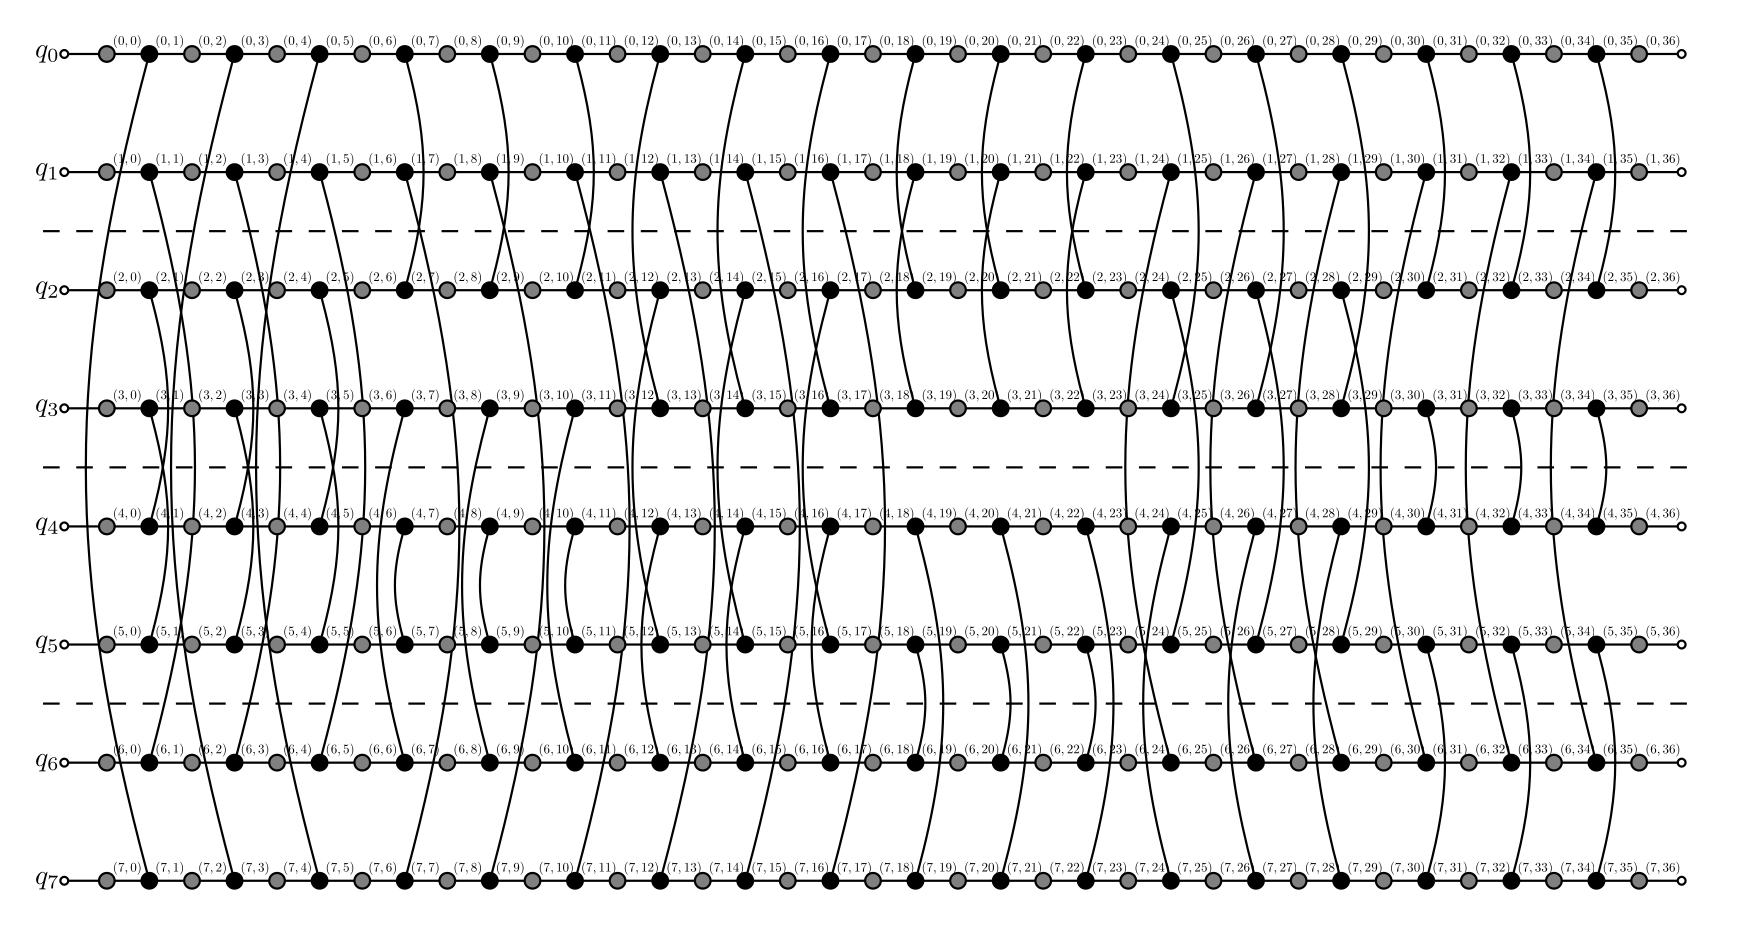

In [12]:
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
from disqco.drawing.tikz_drawing import draw_graph_tikz
from disqco.graphs.quantum_network import QuantumNetwork

qnet = QuantumNetwork(qpu_sizes=qpu_sizes)
%load_ext jupyter_tikz

initial_graph = QuantumCircuitHyperGraph(transpiled_circuit, group_gates=False, qpu_sizes=qpu_sizes)

fig = draw_graph_tikz(initial_graph, qnet, np.array([initial_partition for _ in range(transpiled_circuit.depth())]), fill_background=True)

display(fig)

It can be interesting to view the result in the GCP graph framework too. This essentially a combined graph from each of the slices, where each node is connected to itself in the next graph. The black edges are the multi-qubit gates and the grey edges represent the teleportations (where they ccross the dividing line). If the algorithm is working correctly then only grey edges should cross after partitioning.

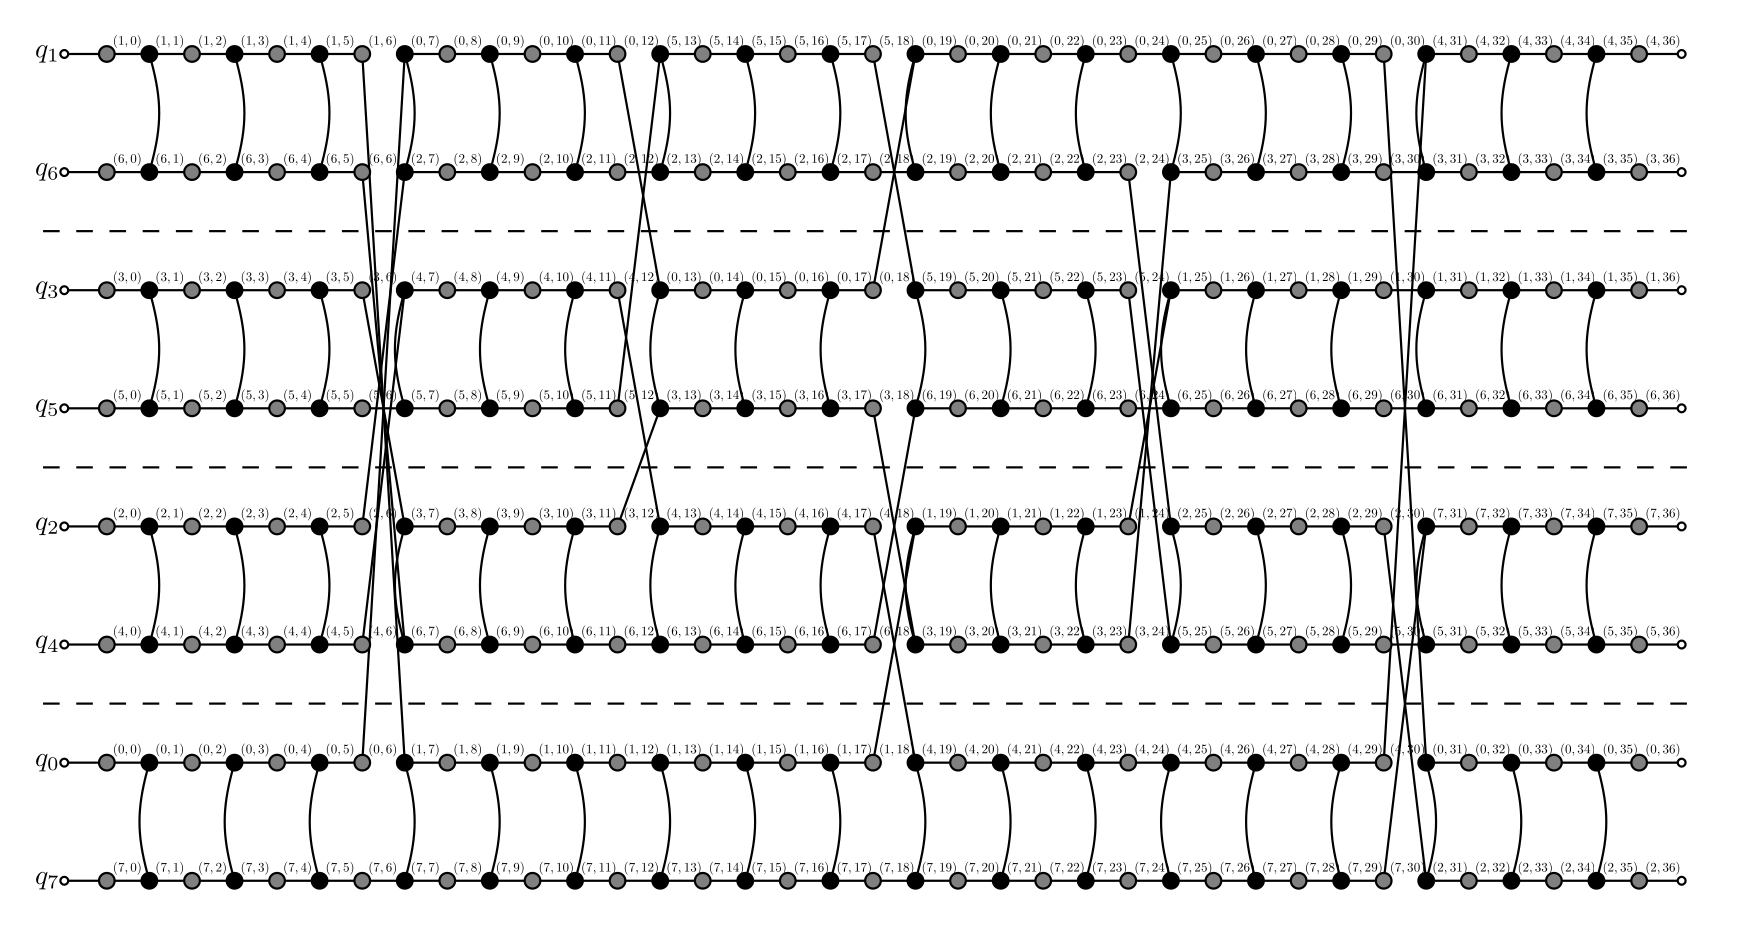

In [13]:

initial_graph = QuantumCircuitHyperGraph(transpiled_circuit, group_gates=False, qpu_sizes=qpu_sizes)

fig = draw_graph_tikz(initial_graph, qnet, partition, fill_background=True)

display(fig)

We can also extract a circuit in the same way as others using the graph and the optimised assignment.

In [14]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor


extractor = PartitionedCircuitExtractor(graph=initial_graph,
                                         partition_assignment=partition,
                                         network=qnet)



basic_partitioned_circuit = extractor.extract_partitioned_circuit()

basic_partitioned_circuit_EPR = transpile(basic_partitioned_circuit, basis_gates=['cp','u','EPR'])

print(f"Depth of partitioned circuit: {basic_partitioned_circuit.depth()}")

EPR_count = basic_partitioned_circuit_EPR.count_ops()['EPR']
print(f"EPR count in partitioned circuit: {EPR_count}")



Depth of partitioned circuit: 242
EPR count in partitioned circuit: 24


In some cases, we can improve the result by performing static partitioning first (using the OEE algorithm). However, for some circuit types, the cost from FGP may end up higher than the static cost.

In [15]:
start = time.time()
partition, cost, mapping = main_algorithm(circuit=transpiled_circuit, 
                                          qpu_info=qpu_sizes,
                                          initial_partition=initial_partition,
                                          remove_singles=False,
                                          choose_initial=False)
stop = time.time()

print(f"Teleportation cost: {cost}", f"Time taken: {stop-start}")

Initial cost of partition:  69
Cost after static OEE:  45
Teleportation cost: 24 Time taken: 0.003564119338989258
